In [1]:
!pip install kneed

In [2]:
import sys
sys.path.append("../../")

from src.statistics.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Basic configuration
DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
p_threshold = 0.05
min_pairs = 20

window_shifts = 12
shift_size = 1

std_dev = 2
exit_std_dev = 0.5
window = 50
hr_window = 25
hr_recalc = 3

preference = None  

base_input_path = "../../data/raw/" 
input_filename = "nasdaq_daily.parquet" 
base_output_path = "../../data/results/" 
output_filename = "Cluster_Bollinger_Sliding.parquet"

In [4]:
def load_and_prepare_data(file_path):
    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    price_matrix = price_matrix.ffill().bfill()
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

##### Loade Price Data

In [5]:
input_data_path = f"{base_input_path}{input_filename}"
output_path = f"{base_output_path}{output_filename}"

price_matrix, symbols = load_and_prepare_data(input_data_path)

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 98
Total trading days: 987



$$ \text{Rendite} = \frac{1}{T} \sum_{t=1}^{T} \frac{P_t - P_{t-1}}{P_{t-1}} \times \text{Trading days per year} $$


$$ \text{Volatilität} = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} \left( \frac{P_t - P_{t-1}}{P_{t-1}} - \mu \right)^2} \times \sqrt{\text{Trading days per year}} $$


In [6]:
def calculate_metrics(price_matrix):
    returns = price_matrix.pct_change().mean() * DATE_CONFIG['TRADING_DAYS_PER_YEAR']
    metrics = pd.DataFrame(returns, columns=['returns'])
    metrics['volatility'] = price_matrix.pct_change().std() * np.sqrt(DATE_CONFIG['TRADING_DAYS_PER_YEAR'])
    return metrics

##### Validate metrics

In [7]:
metrics = calculate_metrics(price_matrix)
print("Erste 5 Zeilen der Metriken:")
print(metrics.head())
print("\nBeschreibung der Metriken:")
print(metrics.describe())

Erste 5 Zeilen der Metriken:
         returns  volatility
symbol                      
AAF.L   0.182975    0.336650
AAL.L   0.118102    0.403779
ABF.L   0.027631    0.250263
ADM.L   0.041431    0.272685
AHT.L   0.127775    0.317220

Beschreibung der Metriken:
         returns  volatility
count  98.000000   98.000000
mean    0.105918    0.273853
std     0.115051    0.059466
min    -0.111803    0.154173
25%     0.027157    0.236768
50%     0.094072    0.265661
75%     0.171602    0.306870
max     0.552316    0.437505


##### Scale Transform
The StandardScaler transforms our features (returns and volatility) to have zero mean and unit variance, which eliminates the scale difference between our variables and prevents higher magnitude features from dominating. This standardization is crucial for many machine learning algorithms as it ensures that all features contribute equally to the model and helps prevent numerical instabilities during the optimization process.

In [8]:
def scale_metrics(metrics):
    scaler = StandardScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(metrics),
        columns=metrics.columns,
        index=metrics.index
    )
    return scaled

In [9]:
X = scale_metrics(metrics)
print("Erste 5 Zeilen der skalierten Daten:")
print(X.head())
print("\nBeschreibung der skalierten Daten:")
print(X.describe())

Erste 5 Zeilen der skalierten Daten:
         returns  volatility
symbol                      
AAF.L   0.673205    1.061455
AAL.L   0.106443    2.196133
ABF.L  -0.683956   -0.398740
ADM.L  -0.563392   -0.019739
AHT.L   0.190950    0.733035

Beschreibung der skalierten Daten:
            returns    volatility
count  9.800000e+01  9.800000e+01
mean  -1.586033e-17 -5.092298e-16
std    1.005141e+00  1.005141e+00
min   -1.902126e+00 -2.022928e+00
25%   -6.880970e-01 -6.268293e-01
50%   -1.034959e-01 -1.384636e-01
75%    5.738475e-01  5.580961e-01
max    3.899964e+00  2.766195e+00


# Affinity Propagation Clustering

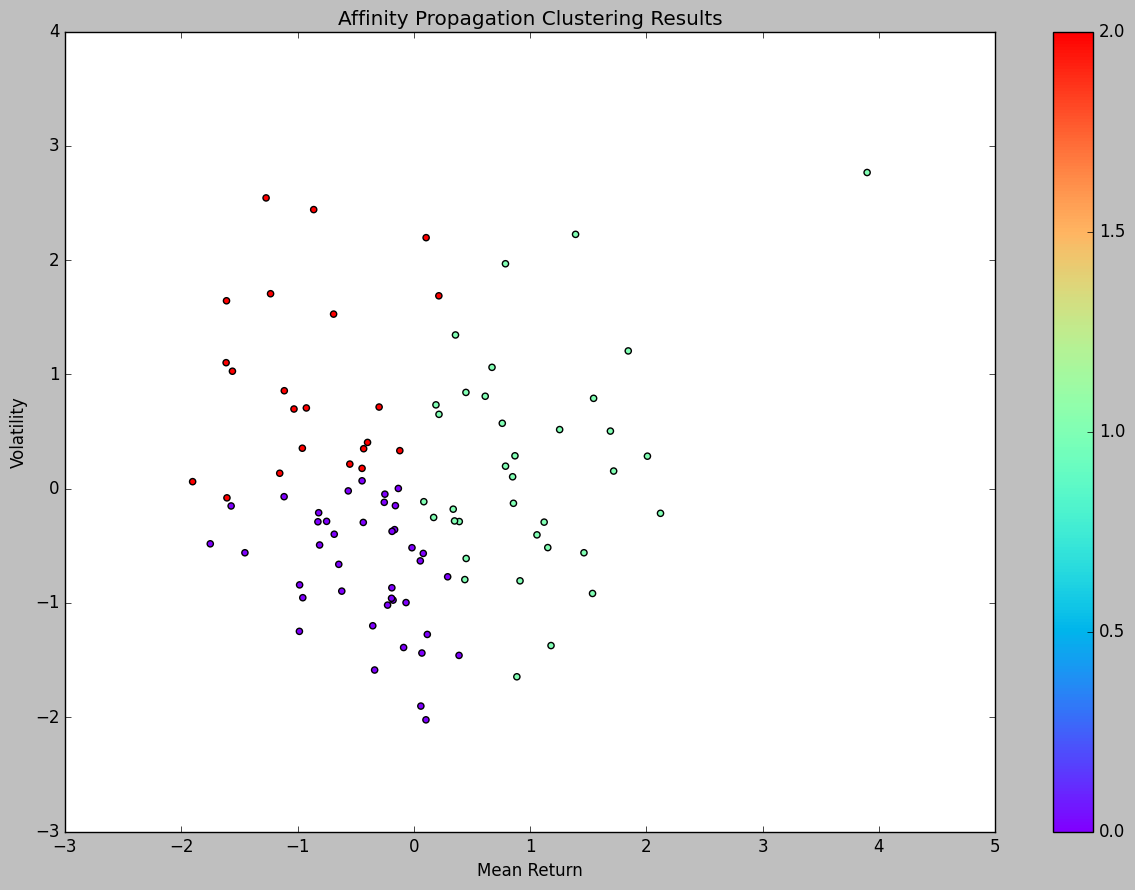

In [10]:
if preference is None:
    ap = AffinityPropagation()
else:
    ap = AffinityPropagation(preference=preference)
ap.fit(X)
labels1 = ap.predict(X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

In [11]:
def get_top_pairs(X, ap, price_matrix, min_pairs=min_pairs, p_threshold=p_threshold):
    scores = []
    
    for cluster_id in np.unique(ap.labels_):
        cluster_mask = ap.labels_ == cluster_id
        cluster_symbols = X.index[cluster_mask]
        center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
        
        for i in range(len(cluster_symbols)):
            for j in range(i+1, len(cluster_symbols)):
                symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                
                dist1 = np.linalg.norm(X.loc[symbol1] - center)
                dist2 = np.linalg.norm(X.loc[symbol2] - center)
                center_dist = (dist1 + dist2) / 2
                
                profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                
                series1 = price_matrix[symbol1]
                series2 = price_matrix[symbol2]
                score, pvalue, _ = coint(series1, series2)
                
                if pvalue < p_threshold:
                    scores.append({
                        'pair': (symbol1, symbol2),
                        'center_dist': center_dist,
                        'profile_diff': profile_diff,
                        'pvalue': pvalue,
                        'cluster': cluster_id
                    })

    scores_df = pd.DataFrame(scores)
    
    # Überprüfen, ob die DataFrame leer ist
    if len(scores_df) == 0:
        print(f"Keine cointegrierten Paare mit p-value < {p_threshold} gefunden.")
        return [], pd.DataFrame()

    scores_df['center_dist_norm'] = (scores_df['center_dist'] - scores_df['center_dist'].min()) / \
                                   (scores_df['center_dist'].max() - scores_df['center_dist'].min())
    scores_df['profile_diff_norm'] = (scores_df['profile_diff'] - scores_df['profile_diff'].min()) / \
                                    (scores_df['profile_diff'].max() - scores_df['profile_diff'].min())

    scores_df['combined_score'] = 0.6 * scores_df['center_dist_norm'] + \
                                 0.4 * scores_df['profile_diff_norm']
    
    scores_df = scores_df.sort_values('combined_score')
    
    while len(scores_df) < min_pairs and p_threshold < 0.1:
        p_threshold += 0.05
        scores = []
        for cluster_id in np.unique(ap.labels_):
            cluster_mask = ap.labels_ == cluster_id
            cluster_symbols = X.index[cluster_mask]
            center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
            
            for i in range(len(cluster_symbols)):
                for j in range(i+1, len(cluster_symbols)):
                    symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                    dist1 = np.linalg.norm(X.loc[symbol1] - center)
                    dist2 = np.linalg.norm(X.loc[symbol2] - center)
                    center_dist = (dist1 + dist2) / 2
                    profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                    score, pvalue, _ = coint(series1, series2)
                    
                    if pvalue < p_threshold:
                        scores.append({
                            'pair': (symbol1, symbol2),
                            'center_dist': center_dist,
                            'profile_diff': profile_diff,
                            'pvalue': pvalue,
                            'cluster': cluster_id
                        })
        
        scores_df = pd.DataFrame(scores)
        if len(scores) > 0:
            scores_df['center_dist_norm'] = (scores_df['center_dist'] - scores_df['center_dist'].min()) / \
                                          (scores_df['center_dist'].max() - scores_df['center_dist'].min())
            scores_df['profile_diff_norm'] = (scores_df['profile_diff'] - scores_df['profile_diff'].min()) / \
                                           (scores_df['profile_diff'].max() - scores_df['profile_diff'].min())
            scores_df['combined_score'] = 0.6 * scores_df['center_dist_norm'] + \
                                        0.4 * scores_df['profile_diff_norm']
            scores_df = scores_df.sort_values('combined_score')
    
    num_pairs = min(len(scores_df), min_pairs)
    print(f"Found {len(scores_df)} pairs with p-value < {p_threshold}")
    return scores_df['pair'].tolist()[:num_pairs], scores_df[:num_pairs]

In [12]:
top_pairs, scores_df = get_top_pairs(X, ap, price_matrix, min_pairs=20)

print("\nTop pairs details:")
if not scores_df.empty:
    print(scores_df[['pair', 'center_dist', 'profile_diff', 'pvalue', 'combined_score', 'cluster']])
else:
    print("Keine Paare gefunden.")

Found 135 pairs with p-value < 0.05

Top pairs details:
                 pair  center_dist  profile_diff    pvalue  combined_score  \
0      (ABF.L, BKG.L)     0.251346      0.157280  0.023908        0.020596   
112  (DPLM.L, LLOY.L)     0.208356      0.415729  0.045141        0.030421   
61    (PHNX.L, RKT.L)     0.308851      0.366848  0.028832        0.052552   
123   (MNG.L, PSON.L)     0.315852      0.631705  0.044904        0.075881   
67    (PHNX.L, SVT.L)     0.393454      0.412626  0.034811        0.078242   
66    (PHNX.L, SSE.L)     0.389198      0.432604  0.029686        0.078759   
64   (PHNX.L, SMIN.L)     0.399068      0.448122  0.035323        0.082583   
132     (HL.L, KGF.L)     0.356706      0.697013  0.004481        0.091795   
43   (LGEN.L, PHNX.L)     0.388760      0.678708  0.005451        0.098634   
70     (PHNX.L, UU.L)     0.452085      0.561640  0.031794        0.105572   
117    (INF.L, MNG.L)     0.617518      0.041163  0.034321        0.106265   
40    (L

The number of clusters is: 3


<Figure size 1200x600 with 0 Axes>

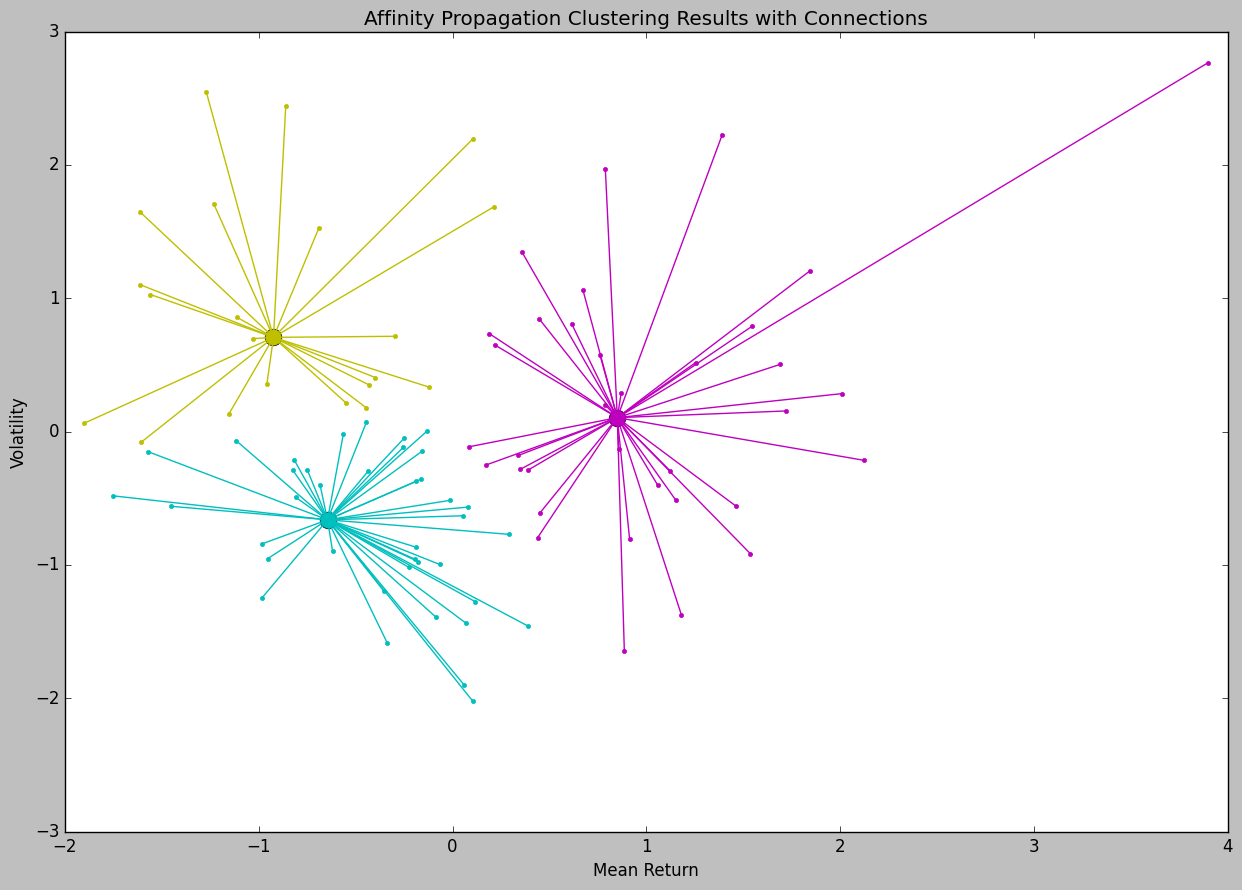

In [13]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation Clustering Results with Connections')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')
plt.show()

In [14]:
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())

cluster_size_limit = 1000
counts = clustered_series_ap.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print("Number of clusters:", len(ticker_count))
print("Number of Pairs:", (ticker_count*(ticker_count-1)).sum())

Number of clusters: 3
Number of Pairs: 3282


Analyzing pairs: 100%|██████████| 780/780 [00:09<00:00, 85.72it/s]



Analysis complete!
Found 91 cointegrated pairs
Total pairs analyzed: 780

Cluster 0 pairs:
ABF.L - BKG.L
ADM.L - HIK.L
ADM.L - ITRK.L
ALW.L - DGE.L
ALW.L - LSEG.L
ALW.L - RKT.L
AZN.L - HSX.L
AZN.L - SDR.L
AZN.L - SSE.L
BNZL.L - LSEG.L
BNZL.L - SDR.L
BNZL.L - SSE.L
BNZL.L - UU.L
CTEC.L - RKT.L
CTEC.L - WPP.L
DGE.L - LSEG.L
EXPN.L - LGEN.L
EXPN.L - RKT.L
FCIT.L - LSEG.L
HSX.L - SMIN.L
HSX.L - VOD.L
LAND.L - LGEN.L
LAND.L - LMP.L
LAND.L - LSEG.L
LAND.L - NG.L
LAND.L - PHNX.L
LAND.L - RIO.L
LAND.L - RKT.L
LAND.L - SBRY.L
LAND.L - SDR.L
LAND.L - SGRO.L
LAND.L - SMIN.L
LAND.L - SN.L
LAND.L - SSE.L
LAND.L - SVT.L
LAND.L - TSCO.L
LAND.L - ULVR.L
LAND.L - UU.L
LAND.L - VOD.L
LAND.L - WPP.L
LGEN.L - LMP.L
LGEN.L - LSEG.L
LGEN.L - NG.L
LGEN.L - PHNX.L
LGEN.L - RIO.L
LGEN.L - RKT.L
LGEN.L - SBRY.L
LGEN.L - SDR.L
LGEN.L - SGRO.L
LGEN.L - SMIN.L
LGEN.L - SN.L
LGEN.L - SSE.L
LGEN.L - SVT.L
LGEN.L - TSCO.L
LGEN.L - ULVR.L
LGEN.L - UTG.L
LGEN.L - UU.L
LGEN.L - VOD.L
LGEN.L - WPP.L
NG.L - SDR.L
PHNX.L 

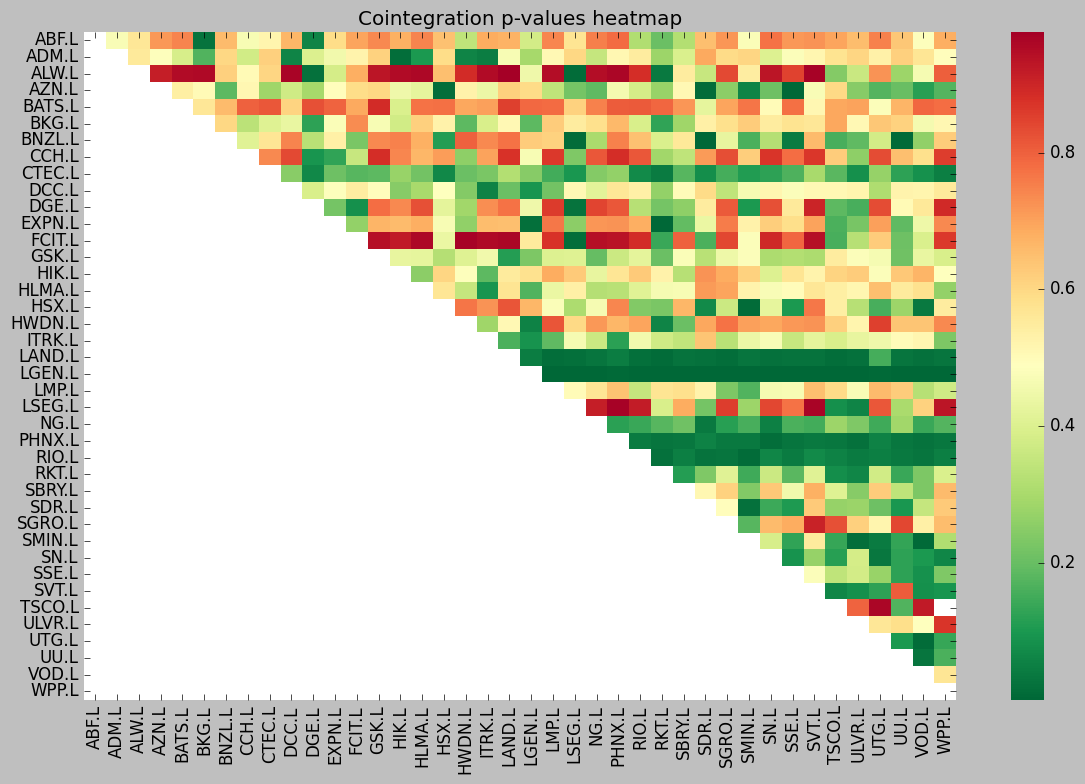

Analyzing pairs: 100%|██████████| 630/630 [00:07<00:00, 85.54it/s]



Analysis complete!
Found 36 cointegrated pairs
Total pairs analyzed: 630

Cluster 1 pairs:
AHT.L - IMI.L
AUTO.L - AV.L
AUTO.L - DPLM.L
AUTO.L - III.L
AUTO.L - LLOY.L
AUTO.L - MKS.L
AUTO.L - NXT.L
AUTO.L - RR.L
AV.L - DPLM.L
AV.L - IHG.L
AV.L - III.L
AV.L - LLOY.L
AV.L - PSH.L
AV.L - REL.L
AV.L - RR.L
BA.L - INF.L
BA.L - MNG.L
BARC.L - SMDS.L
BEZ.L - IMB.L
CPG.L - HSBA.L
CPG.L - STAN.L
DPLM.L - LLOY.L
DPLM.L - MKS.L
DPLM.L - NXT.L
DPLM.L - RR.L
IMI.L - NXT.L
INF.L - MNG.L
LLOY.L - NXT.L
LLOY.L - RR.L
MNG.L - MRO.L
MNG.L - NXT.L
MNG.L - PSH.L
MNG.L - PSON.L
MNG.L - REL.L
MNG.L - RR.L
MNG.L - SGE.L


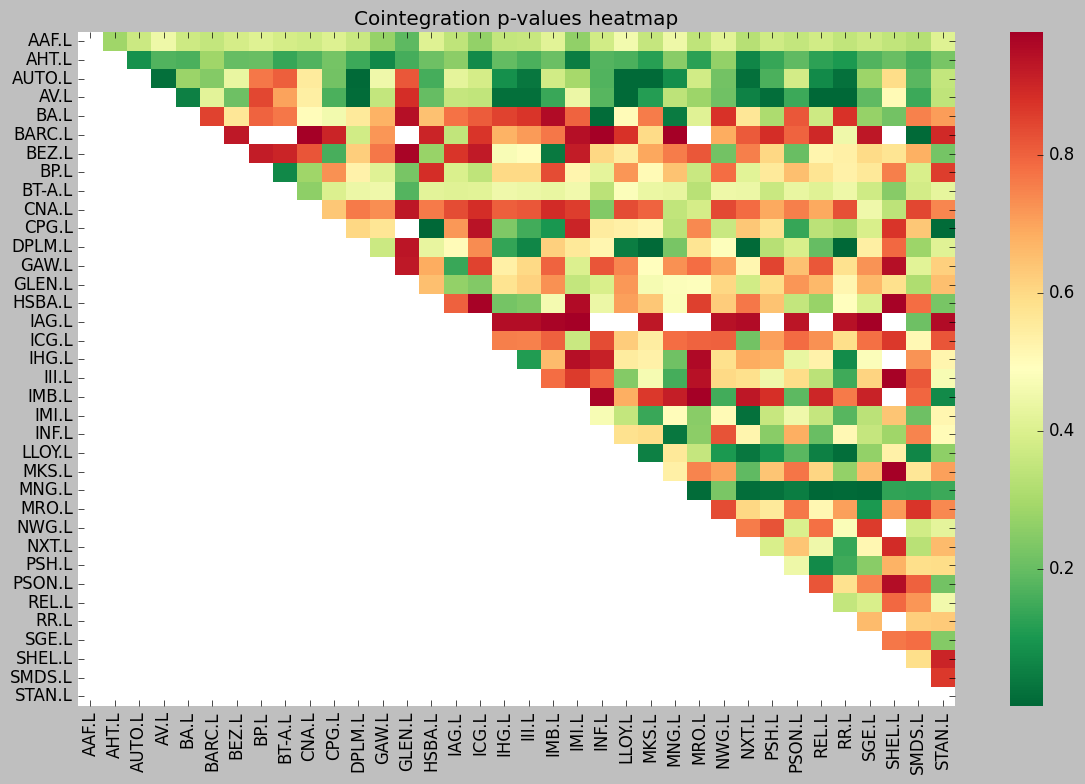

Analyzing pairs: 100%|██████████| 231/231 [00:02<00:00, 86.38it/s]



Analysis complete!
Found 8 cointegrated pairs
Total pairs analyzed: 231

Cluster 2 pairs:
AAL.L - FRES.L
AAL.L - WTB.L
ENT.L - SPX.L
FRES.L - PRU.L
FRES.L - STJ.L
HL.L - KGF.L
MNDI.L - PSN.L
RMV.L - SMT.L


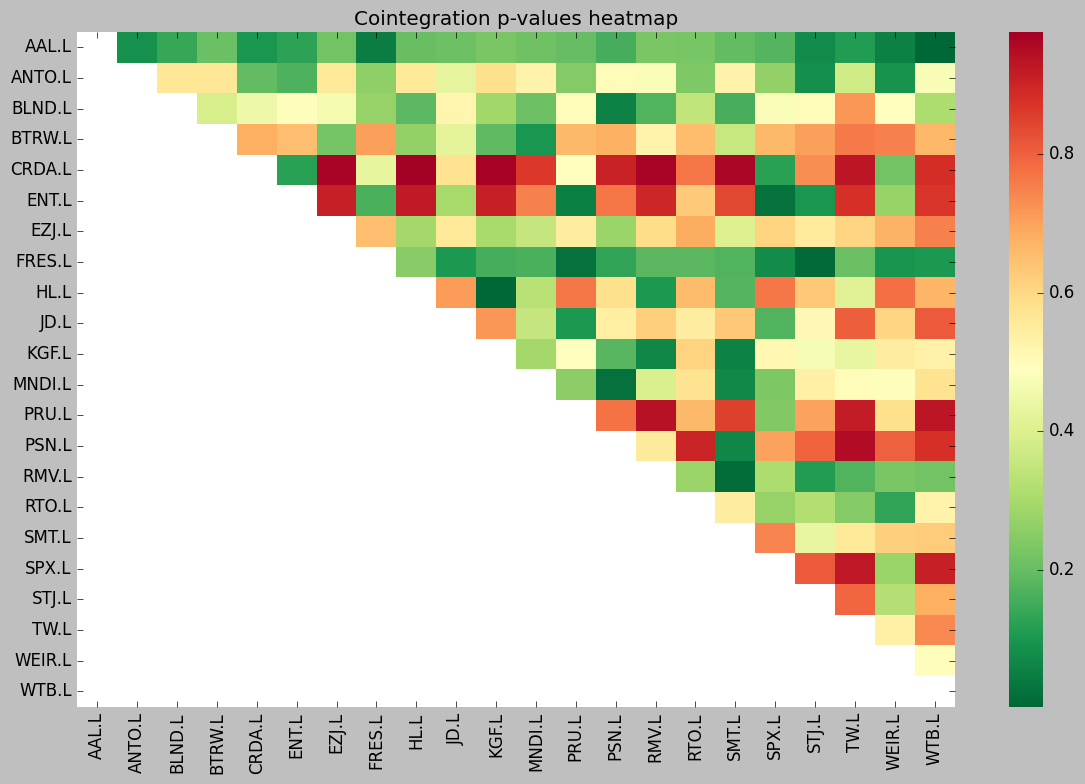

In [15]:
all_pairs_with_clusters = []

for cluster_id in np.unique(ap.labels_):
    cluster_mask = ap.labels_ == cluster_id
    cluster_symbols = X.index[cluster_mask]
    
    if len(cluster_symbols) > 1:
        cluster_prices = price_matrix[cluster_symbols]
        score_matrix, pvalue_matrix, pairs, _ = analyze_pairs(
            cluster_prices,
            pvalue_threshold=0.05
        )
        
        if len(pairs) > 0:
            for pair in pairs:
                all_pairs_with_clusters.append({
                    'pair': pair,
                    'cluster': cluster_id
                })
            print(f"\nCluster {cluster_id} pairs:")
            for pair in pairs:
                print(f"{pair[0]} - {pair[1]}")
                
            plot_cointegration_heatmap(pvalue_matrix, cluster_symbols)

all_pairs = [item['pair'] for item in all_pairs_with_clusters]

In [16]:
stocks = np.unique([stock for pair in top_pairs for stock in pair])
X_data = pd.DataFrame(index=X.index, data=X).T  
in_pairs_series = pd.Series(index=stocks, data=[ap.labels_[list(X.index).index(stock)] for stock in stocks])
X_pairs = X_data.T.loc[stocks]

In [17]:
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

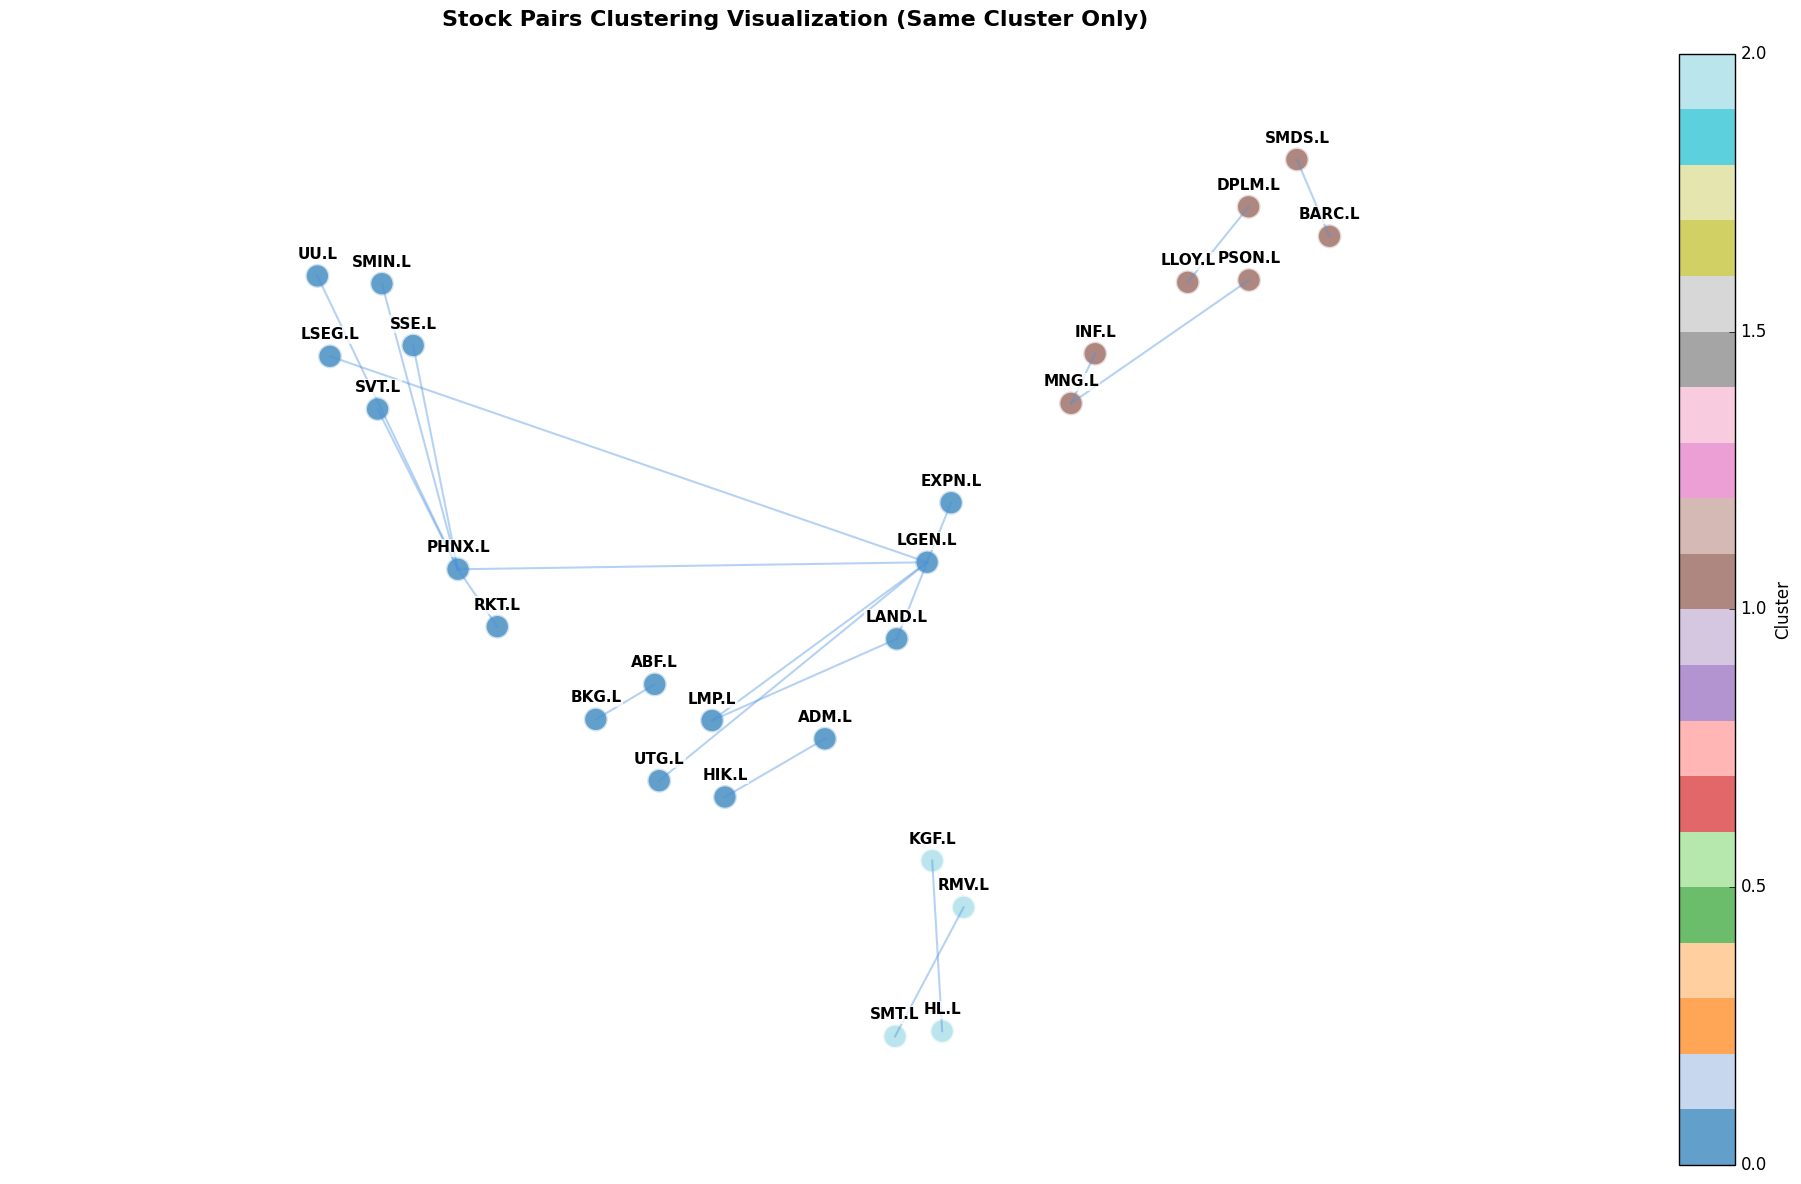

In [18]:
plt.figure(figsize=(20,12), facecolor='white')
plt.clf()
plt.gca().set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.7)

for pair in top_pairs:
    cluster = scores_df[scores_df['pair'] == pair]['cluster'].values[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    loc2 = X_pairs.index.get_loc(pair[1])
    x1, y1 = X_tsne[loc1, :]
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], '-', alpha=0.4, linewidth=1.5, color='#4a90e2')

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     s=300,
                     alpha=0.7,
                     c=in_pairs_series.values,
                     cmap='tab20',
                     edgecolor='white',
                     linewidth=2)

for x, y, name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):
    plt.annotate(name,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                va='bottom',
                fontsize=11,
                fontweight='bold',
                bbox=dict(facecolor='white', 
                         edgecolor='none',
                         alpha=0.7,
                         pad=1))

plt.title('Stock Pairs Clustering Visualization (Same Cluster Only)', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.axis('off')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [19]:
def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window_number, window=window, hr_window=hr_window, hr_recalc=hr_recalc, std_dev=std_dev, exit_std_dev=exit_std_dev):
    trades = []
    trade_id = 0
    active_trades = []  
    
    S1_full = pd.concat([S1_train, S1_test])
    S2_full = pd.concat([S2_train, S2_test])
    
    days_since_recalc = 0
    current_hedge_ratio = None
    
    for i in range(len(S1_test)):
        current_idx = S1_train.shape[0] + i
        current_date = S1_test.index[i]
        
        if days_since_recalc >= hr_recalc or current_hedge_ratio is None:
            if current_idx >= hr_window:
                hr_data_1 = S1_full.iloc[current_idx-hr_window:current_idx]
                hr_data_2 = S2_full.iloc[current_idx-hr_window:current_idx]
                model = sm.OLS(hr_data_1, hr_data_2)
                current_hedge_ratio = model.fit().params[0]
                days_since_recalc = 0
        
        days_since_recalc += 1
        
        if current_hedge_ratio is None:
            continue
            
        spread_full = S1_full - (S2_full * current_hedge_ratio)
        spread_window = spread_full.iloc[:current_idx+1]
        
        if len(spread_window) < window:
            continue
            
        rolling_mean = spread_window.rolling(window=window).mean().iloc[-1]
        rolling_std = spread_window.rolling(window=window).std().iloc[-1]
        
        if pd.isna(rolling_std) or rolling_std == 0:
            continue
            
        upper_band = rolling_mean + (rolling_std * std_dev)
        lower_band = rolling_mean - (rolling_std * std_dev)
        
        current_spread = spread_full.iloc[current_idx]

        if current_spread > upper_band:
            trade_entry = {
                'trade_id': trade_id,
                'symbol1': symbol1,
                'symbol2': symbol2,
                'entry_date': current_date,
                'type': 'short',
                'status': 'active',
                'entry_prices': {
                    symbol1: {'price': S1_test.iloc[i], 'type': 'short'},
                    symbol2: {'price': S2_test.iloc[i], 'type': 'long'}
                },
                'hedge_ratio': current_hedge_ratio,
                'window': window_number
            }
            active_trades.append(trade_entry)
            trade_id += 1
            
        elif current_spread < lower_band:
            trade_entry = {
                'trade_id': trade_id,
                'symbol1': symbol1,
                'symbol2': symbol2,
                'entry_date': current_date,
                'type': 'long', 
                'status': 'active',
                'entry_prices': {
                    symbol1: {'price': S1_test.iloc[i], 'type': 'long'},
                    symbol2: {'price': S2_test.iloc[i], 'type': 'short'}
                },
                'hedge_ratio': current_hedge_ratio,
                'window': window_number
            }
            active_trades.append(trade_entry)
            trade_id += 1

        for trade in active_trades:
            if trade['status'] == 'active':

                upper_exit = rolling_mean + (rolling_std * exit_std_dev)
                lower_exit = rolling_mean - (rolling_std * exit_std_dev)

                if (trade['type'] == 'short' and current_spread < upper_exit and current_spread > lower_exit) or \
                   (trade['type'] == 'long' and current_spread < upper_exit and current_spread > lower_exit):
                    
                    trade['status'] = 'closed'
                    
                    for symbol in [symbol1, symbol2]:
                        trades.append({
                            'trade_id': trade['trade_id'],
                            'symbol': symbol,
                            'entry_date': trade['entry_date'],
                            'entry_price': trade['entry_prices'][symbol]['price'],
                            'exit_date': current_date,
                            'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                            'position_type': trade['entry_prices'][symbol]['type'],
                            'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                            'exit_type': 'target',
                            'window': trade['window'],
                            'hedge_ratio': trade['hedge_ratio']
                        })

    active_trades = [t for t in active_trades if t['status'] == 'active']
    return trades, active_trades

In [20]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

In [21]:
def backtest_pairs_sliding(price_matrix, initial_start_date, initial_end_date, base_output_path, output_filename, window_shifts=window_shifts, p_threshold=p_threshold, shift_size=shift_size):
    all_trades = []
    ongoing_trades = []
    
    print(f"Price Matrix Zeitraum: {price_matrix.index.min()} bis {price_matrix.index.max()}")
    
    for window_number in range(window_shifts):
        current_start = initial_start_date + pd.DateOffset(months=window_number*shift_size)
        current_end = initial_end_date + pd.DateOffset(months=window_number*shift_size)
        
        print(f"\nAnalyse {window_number+1}/{window_shifts}")
        print(f"Cluster-Fenster: {current_start} bis {current_end}")
        
        cluster_data = price_matrix[(price_matrix.index >= current_start) & 
                                  (price_matrix.index <= current_end)].copy()
        
        if len(cluster_data) == 0:
            print(f"Keine Daten für Fenster {window_number+1}")
            continue
            
        print(f"Cluster Daten: {len(cluster_data)} Tage")
            
        metrics = calculate_metrics(cluster_data)
        X = scale_metrics(metrics)
        
        if preference is None:
            ap = AffinityPropagation()
        else:
            ap = AffinityPropagation(preference=preference)
        ap.fit(X)
        
        # Zeige die Anzahl der Cluster an
        print(f"Anzahl der erzeugten Cluster: {len(np.unique(ap.labels_))}")
        
        potential_pairs = []
        
        for cluster_id in np.unique(ap.labels_):
            cluster_mask = ap.labels_ == cluster_id
            cluster_symbols = X.index[cluster_mask]
            center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
            
            for i in range(len(cluster_symbols)):
                for j in range(i+1, len(cluster_symbols)):
                    symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                    
                    dist1 = np.linalg.norm(X.loc[symbol1] - center)
                    dist2 = np.linalg.norm(X.loc[symbol2] - center)
                    center_dist = (dist1 + dist2) / 2
                    profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                    
                    s1 = cluster_data[symbol1].dropna()
                    s2 = cluster_data[symbol2].dropna()
                    
                    if len(s1) > 0 and len(s2) > 0:
                        try:
                            score, pvalue, _ = coint(s1, s2)
                            
                            if pvalue < p_threshold:
                                potential_pairs.append({
                                    'pair': (symbol1, symbol2),
                                    'center_dist': center_dist,
                                    'profile_diff': profile_diff,
                                    'pvalue': pvalue,
                                    'cluster': cluster_id
                                })
                        except:
                            continue
        
        if not potential_pairs:
            print(f"Keine cointegrierten Paare gefunden für Fenster {window_number+1}")
            continue
            
        pairs_df = pd.DataFrame(potential_pairs)
        
        pairs_df['center_dist_norm'] = (pairs_df['center_dist'] - pairs_df['center_dist'].min()) / \
                                     (pairs_df['center_dist'].max() - pairs_df['center_dist'].min())
        pairs_df['profile_diff_norm'] = (pairs_df['profile_diff'] - pairs_df['profile_diff'].min()) / \
                                      (pairs_df['profile_diff'].max() - pairs_df['profile_diff'].min())
        
        pairs_df['combined_score'] = 0.6 * pairs_df['center_dist_norm'] + \
                                   0.4 * pairs_df['profile_diff_norm']
        
        pairs_df = pairs_df.sort_values('combined_score')
        top_pairs = pairs_df['pair'].tolist()[:min_pairs]
        
        print(f"Gefundene cointegrierte Paare für Fenster {window_number+1}: {len(top_pairs)}")
        
        trade_start = current_end
        trade_end = trade_start + pd.DateOffset(months=1)
        
        print(f"Trading-Zeitraum: {trade_start} bis {trade_end}")
        
        trading_data = price_matrix[(price_matrix.index > trade_start) & 
                                  (price_matrix.index <= trade_end)].copy()
        
        print(f"Trading Daten: {len(trading_data)} Tage")
        
        if len(trading_data) == 0:
            print(f"Warnung: Kein Trading-Zeitraum verfügbar nach {trade_start}")
            continue
        
        # Bestehende Trades überprüfen und ggf. schließen
        updated_ongoing_trades = []
        closed_trade_ids = set()
        
        for open_trade in ongoing_trades:
            symbol1, symbol2 = open_trade['symbol1'], open_trade['symbol2']
            
            if symbol1 in trading_data.columns and symbol2 in trading_data.columns:
                still_active = True
                
                for idx, date in enumerate(trading_data.index):
                    # Hedge Ratio aus dem offenen Trade nehmen
                    current_hedge_ratio = open_trade['hedge_ratio']
                    
                    if pd.isna(current_hedge_ratio) or current_hedge_ratio is None:
                        continue
                    
                    # Historische Daten bis zum Entry Datum verwenden
                    hist_data = price_matrix[(price_matrix.index <= open_trade['entry_date'])]
                    
                    if len(hist_data) == 0:
                        continue
                    
                    # Spread berechnen für historische Daten
                    spread_hist = hist_data[symbol1] - (hist_data[symbol2] * current_hedge_ratio)
                    
                    if len(spread_hist) < window:
                        continue
                    
                    # Statistische Werte berechnen
                    rolling_mean = spread_hist.rolling(window=window).mean().iloc[-1]
                    rolling_std = spread_hist.rolling(window=window).std().iloc[-1]
                    
                    if pd.isna(rolling_std) or rolling_std == 0:
                        continue
                    
                    # Exit-Bänder festlegen
                    upper_exit = rolling_mean + (rolling_std * exit_std_dev)
                    lower_exit = rolling_mean - (rolling_std * exit_std_dev)
                    
                    # Aktuellen Spread berechnen
                    current_spread = trading_data[symbol1].iloc[idx] - (trading_data[symbol2].iloc[idx] * current_hedge_ratio)
                    
                    # Exit-Bedingung prüfen
                    if (open_trade['type'] == 'short' and current_spread < upper_exit and current_spread > lower_exit) or \
                       (open_trade['type'] == 'long' and current_spread < upper_exit and current_spread > lower_exit):
                        
                        open_trade['status'] = 'closed'
                        closed_trade_ids.add(open_trade['trade_id'])
                        
                        for symbol in [symbol1, symbol2]:
                            all_trades.append({
                                'trade_id': open_trade['trade_id'],
                                'symbol': symbol,
                                'entry_date': open_trade['entry_date'],
                                'entry_price': open_trade['entry_prices'][symbol]['price'],
                                'exit_date': date,
                                'exit_price': trading_data.loc[date, symbol],
                                'position_type': open_trade['entry_prices'][symbol]['type'],
                                'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                                'exit_type': 'target',
                                'window': open_trade['window'],
                                'hedge_ratio': open_trade['hedge_ratio']
                            })
                        
                        still_active = False
                        break
                
                if still_active:
                    updated_ongoing_trades.append(open_trade)
        
        ongoing_trades = updated_ongoing_trades
        
        # Neue Trades generieren
        trade_count = 0
        for pair in top_pairs:
            symbol1, symbol2 = pair
            
            # Get clean segments for trading
            train_s1 = cluster_data[symbol1].dropna()
            train_s2 = cluster_data[symbol2].dropna() 
            test_s1 = trading_data[symbol1].dropna()
            test_s2 = trading_data[symbol2].dropna()
            
            if len(train_s1) == 0 or len(train_s2) == 0 or len(test_s1) == 0 or len(test_s2) == 0:
                continue
            
            new_trades, active_new_trades = trade(
                train_s1, 
                train_s2,
                test_s1, 
                test_s2,
                symbol1, symbol2,
                window_number=window_number + 1
            )
            
            if new_trades:
                trade_count += len(new_trades)
                all_trades.extend(new_trades)
            
            ongoing_trades.extend(active_new_trades)
        
        print(f"Neue geschlossene Trades in diesem Fenster: {trade_count}")
        print(f"Aktuell offene Trades: {len(ongoing_trades)}")
    
    trades_df = pd.DataFrame(all_trades)
    
    if len(trades_df) > 0:
        full_output_path = f"{base_output_path}{output_filename}"
        trades_df.to_parquet(full_output_path)
        
        print("\nTrading Zusammenfassung:")
        print(f"Gesamtanzahl Trades: {len(trades_df)}")
        print(f"Unique Paare gehandelt: {len(trades_df[['symbol', 'paired_symbol']].drop_duplicates())}")
        print(f"Zeitraum: {trades_df['entry_date'].min()} bis {trades_df['exit_date'].max()}")
        
        print("\nTrades pro Fenster:")
        print(trades_df['window'].value_counts().sort_index())
    else:
        print("Keine Trades generiert!")
        
    return trades_df

In [22]:
trades_df = backtest_pairs_sliding(
    price_matrix=price_matrix,
    initial_start_date=DATE_CONFIG['TRAIN_START'],
    initial_end_date=DATE_CONFIG['TRAIN_END'], 
    base_output_path=base_output_path,
    output_filename=output_filename
)

Price Matrix Zeitraum: 2021-02-02 00:00:00 bis 2024-12-31 00:00:00

Analyse 1/12
Cluster-Fenster: 2021-02-02 00:00:00 bis 2024-01-01 00:00:00
Cluster Daten: 733 Tage
Anzahl der erzeugten Cluster: 2
Gefundene cointegrierte Paare für Fenster 1: 20
Trading-Zeitraum: 2024-01-01 00:00:00 bis 2024-02-01 00:00:00
Trading Daten: 23 Tage
Neue geschlossene Trades in diesem Fenster: 46
Aktuell offene Trades: 64

Analyse 2/12
Cluster-Fenster: 2021-03-02 00:00:00 bis 2024-02-01 00:00:00
Cluster Daten: 736 Tage
Anzahl der erzeugten Cluster: 3
Gefundene cointegrierte Paare für Fenster 2: 20
Trading-Zeitraum: 2024-02-01 00:00:00 bis 2024-03-01 00:00:00
Trading Daten: 21 Tage
Neue geschlossene Trades in diesem Fenster: 32
Aktuell offene Trades: 82

Analyse 3/12
Cluster-Fenster: 2021-04-02 00:00:00 bis 2024-03-01 00:00:00
Cluster Daten: 734 Tage
Anzahl der erzeugten Cluster: 3
Gefundene cointegrierte Paare für Fenster 3: 20
Trading-Zeitraum: 2024-03-01 00:00:00 bis 2024-04-01 00:00:00
Trading Daten: 19 